https://huggingface.co/learn/deep-rl-course/unit4/hands-on

In [1]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym
from gym import spaces


In [2]:
device = "cpu"

In [3]:
class PointAvoidanceEnv(gym.Env):
    def __init__(self, num_falling_points=5, grid_size=5):
        super(PointAvoidanceEnv, self).__init__()

        self.num_falling_points = num_falling_points
        self.grid_size = grid_size
        self.main_point = None
        self.falling_points = None
        self.action_space = spaces.Discrete(2)  # 0: Move left, 1: Move right
        self.observation_space = spaces.Box(low=0, high=1, shape=(
            1+2*3,), dtype=np.float32)
        self.reset()

    def reset(self):
        # Initialize the main point and falling points randomly
        self.main_point = np.array([3,0])
        self.falling_points = np.array([[np.random.randint(0, self.grid_size), 4],
                                        [np.random.randint(0, self.grid_size), 3],
                                        [np.random.randint(0, self.grid_size), 2]])
        return self._get_observation(), []

    def step(self, action):
        assert self.action_space.contains(action)

        # Calculate new position based on chosen action (0: Move left, 1: Move right)
        new_position = self.main_point[0] + np.array([-1, 1])[action]
        # Clip to grid boundaries
        new_position = np.clip(new_position, 0, self.grid_size - 1)

        # Move the main point
        self.main_point = np.array([new_position, self.main_point[1]])

        # Update falling points by making them fall down
        self.falling_points[:, 1] -= 1

        # Calculate rewards and check for collisions
        reward = 0
        done = False
        for n, point in enumerate(self.falling_points):
            if np.array_equal(point, self.main_point):
                reward -= 10
                done = True


            if point[1]<0:
                reward += 1
                self.falling_points[n] = [np.random.randint(0,5), 4]

        return self._get_observation(), reward, done, False, {}

    def _get_observation(self):
        # Concatenate main point and falling point coordinates for observation

        #return np.concatenate((self.main_point[0], self.falling_points[:,1].flatten()))
        return np.append(self.falling_points.flatten(), self.main_point[0])

    def render(self):
        img = np.zeros(shape=(self.grid_size, self.grid_size))
        img[self.main_point[0], self.main_point[1]] = 1
        for point in self.falling_points:
            img[point[0], point[1]] = 2

        return img

    def close(self):
        pass


# Create the custom environment
env = PointAvoidanceEnv()
eval_env = PointAvoidanceEnv()



In [4]:
# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n


In [5]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
# Get a random observation
print("Sample observation", env.observation_space.sample())


_____OBSERVATION SPACE_____ 

The State Space is:  7
Sample observation [0.508631   0.26126274 0.6926124  0.31258458 0.62323415 0.88831425
 0.42204213]


In [6]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample())  # Take a random action



 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 0


In [7]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)


In [8]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes + 1):
        saved_log_probs = []
        rewards = []
        state, _ = env.reset()
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ ,_ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        # Compute the discounted returns at each timestep,
        # as
        #      the sum of the gamma-discounted return at time t (G_t) + the reward at time t
        #
        # In O(N) time, where N is the number of time steps
        # (this definition of the discounted return G_t follows the definition of this quantity
        # shown at page 44 of Sutton&Barto 2017 2nd draft)
        # G_t = r_(t+1) + r_(t+2) + ...

        # Given this formulation, the returns at each timestep t can be computed
        # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order
        # to avoid computing them multiple times)

        # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
        # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...

        ## Given the above, we calculate the returns at timestep t as:
        #               gamma[t] * return[t] + reward[t]
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed
        ## if we were to do it from first to last.

        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            disc_return_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma * disc_return_t + rewards[t])

        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        if np.isnan(returns.std()):
            returns_std = 0
        else:
            returns_std = returns.std()
        returns = (returns - returns.mean()) / (returns_std + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        policy_loss.detach()

        if i_episode % print_every == 0:
            print("Episode {}\tAverage Score: {:.2f}".format(
                i_episode, np.mean(scores_deque)))

    return scores


In [9]:
cartpole_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 50000,
    "n_evaluation_episodes": 10,
    "max_t": 100,
    "gamma": 1.0,
    "lr": 1e-3,
    "env_id": "test",
    "state_space": s_size,
    "action_space": a_size,
}


In [10]:
# Create policy and place it to the device
cartpole_policy = Policy(
    cartpole_hyperparameters["state_space"],
    cartpole_hyperparameters["action_space"],
    cartpole_hyperparameters["h_size"],
).to(device)
cartpole_optimizer = optim.Adam(
    cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])


In [11]:
scores = reinforce(
    cartpole_policy,
    cartpole_optimizer,
    cartpole_hyperparameters["n_training_episodes"],
    cartpole_hyperparameters["max_t"],
    cartpole_hyperparameters["gamma"],
    100,
)


Episode 100	Average Score: -5.33
Episode 200	Average Score: -5.28
Episode 300	Average Score: -5.35
Episode 400	Average Score: -5.57
Episode 500	Average Score: -4.55
Episode 600	Average Score: -5.03
Episode 700	Average Score: -5.23
Episode 800	Average Score: -3.47
Episode 900	Average Score: -5.18
Episode 1000	Average Score: -2.97
Episode 1100	Average Score: -4.03
Episode 1200	Average Score: -2.62
Episode 1300	Average Score: -1.59
Episode 1400	Average Score: -1.04
Episode 1500	Average Score: -2.14
Episode 1600	Average Score: -2.59
Episode 1700	Average Score: -2.54
Episode 1800	Average Score: -2.23
Episode 1900	Average Score: -3.15
Episode 2000	Average Score: -2.16
Episode 2100	Average Score: -1.32
Episode 2200	Average Score: -0.91
Episode 2300	Average Score: -3.27
Episode 2400	Average Score: -2.12
Episode 2500	Average Score: -1.35
Episode 2600	Average Score: -1.13
Episode 2700	Average Score: -0.31
Episode 2800	Average Score: -0.55
Episode 2900	Average Score: -0.36
Episode 3000	Average Sc

In [12]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param policy: The Reinforce agent
    """
    episode_rewards = []
    for episode in range(n_eval_episodes):
        state, _ = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0

        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done, _, info = env.step(action)
            total_rewards_ep += reward

            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward


In [13]:
evaluate_agent(
    eval_env, cartpole_hyperparameters["max_t"], cartpole_hyperparameters["n_evaluation_episodes"], cartpole_policy
)


(55.0, 11.349008767288886)

In [14]:
import imageio

In [15]:

images = []
done = False
state, _ = env.reset()
img = env.render()
images.append(img)
while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action, _ = cartpole_policy.act(state)
    # We directly put next_state = state for recording logic
    state, reward, done, _, info = env.step(action)
    img = env.render()
    images.append(img)
    if len(images)>100:
        break

In [16]:
len(images)

101

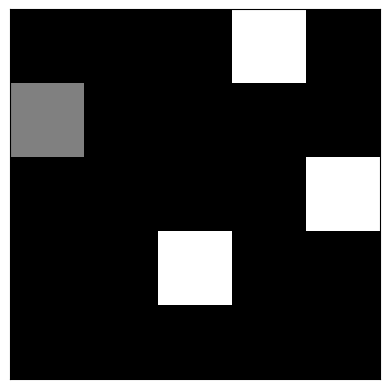

In [17]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create a sequence of grids (5x5) as an example

fig, ax = plt.subplots()
im = ax.imshow(images[0], cmap="gray", origin="lower")
plt.xticks([])
plt.yticks([])


def update(frame):
    im.set_array(images[frame])
    return im,


ani = FuncAnimation(fig, update, frames=len(images), interval=500, blit=True)

# Display the animation in the notebook
HTML(ani.to_jshtml())


In [22]:
torch.save(cartpole_policy, "2023_08_26_fall_Avoider_50000.model")